In [1]:
#!apt-get update
#!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt-get install -y latexmk
#!apt-get install -y texlive-latex-extra
#!apt-get install -y texlive-science
#%pip install -qU langchain-openai
#%pip install pygraphviz
#%pip install pylatex

import os
import re
import json
import networkx as nx
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from rich.console import Console
from rich.syntax import Syntax
from rich.table import Table

In [2]:
def pretty_print(item):
    console = Console()
    with console.pager(styles=True):
        console.print(item)

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [3]:
book_location = 'quantum2'
book_content = "Undertanding Quantum Computing" #@param {type:"string"}
book_author = "Md. Sazzad Hissain Khan"
n_pages = 30 # @param {"type":"integer","placeholder":"40"}

target_readers = "Common university 1st or 2nd year students in department of Computer Science." #@param {type:"string"}
equation_frequency_level = 1 #@param {type:"slider", min:1, max:5, step:1}
do_consider_outline = True #@param {type:"boolean"}
do_consider_previous_sections = True #@param {type:"boolean"}
do_consider_previous_sections_detail = False #@param {type:"boolean"}
additional_requirements = "Try to be factual and verbose while describing any concept. Also put examples." #@param {type:"string"}

# Parameters
max_depth = 2  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

In [4]:
print(f"Book location: {book_location}")
book_location = os.path.abspath(book_location)
print(f"Absolute book location: {book_location}")
os.makedirs(book_location, exist_ok=True)
os.chdir(book_location)
print(f"Current working directory: {os.getcwd()}")

Book location: quantum2
Absolute book location: /Users/hissain/git/github/llmexp/books_prof/quantum2
Current working directory: /Users/hissain/git/github/llmexp/books_prof/quantum2


## Prompt Definition

In [5]:
# Common Prompt
prompt_common = f"""
You are an expert assistant for generating content of technical professional books. You will be writing a book on the following topic: {book_content}.
The total number of pages in the book is about {n_pages}, with an estimated 40 lines per page. Please consider using polite and professional tone.
"""

if target_readers != "":
    prompt_common += f"The intended readers of the book are as follows:\n {target_readers}"
    
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"
    
prompt_abstract = """
You are a LaTeX expert and a creative writer. Your task is to generate an abstract and a disclaimer for a book in LaTeX format.

### Requirements:
1. The book title is: "{title}".

2. The book summary is: 
{summary}

3. The table of contents includes the following chapters:
{toc_list}

### Output Format:
Provide the output strictly in LaTeX format, including the following:
- A section titled "Abstract" summarizing the book's purpose and topics covered.
- A section titled "Disclaimer" stating that the content was generated by an AI and may contain inaccuracies.

### Example LaTeX Output:

\\section*{{Abstract}}
[Your generated abstract goes here.]

\\section*{{Disclaimer}}
[Your generated disclaimer goes here.]

### Instructions:
- Do not include explanations or comments outside the LaTeX code.
- Replace placeholders with fully realized content.
- Avoid including other latex tags including documents and so on. Just output two sections as required.
"""

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above given information, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed. 
Please do not include any extra introductory or conclusory message outside the expected json format.
Enclose the json content between ```json and ``` delimiters.

Please do not include any other json keys except what have been asked for in the following output format.
The output format should be strictly as follows:

```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like you to create content across {n_pages} pages, assuming 20 lines per page.
The summary for this section is as follows:
{section_summary}

Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles. 
Please do not include any extra introductory or conclusory message outside the expected format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """

As part of that, now, you are writing the book of the title: {book_title} and the summary of the book is as follows:
{book_summary}

{toc_and_summary}
{previous_sections}. 

For readability and consistency, please highlights what have been discussed in the previous section/ chapter and whats is being discussed in the current one.

Now, I would like you to create LaTeX content for the current section on: {target}, across {n_pages} pages, assuming 20 lines per page. 
The summary for the current section whose content you will generate is as follows: {section_summary}. Please generate the content.

Please output the content in the following format:
- Enclose the LaTeX content strictly between the delimiters `<|tex_start|>` and `<|tex_end|>`, as shown below:
    - The LaTeX output **must start with** `<|tex_start|>` delimiter.
    - The LaTeX output **must end with** `<|tex_end|>` delimiter.
- Do not include any other messages, comments, or text outside these delimiters.
- If you have equations in generated response, for equations, use the `equation` or `align` environment; do not use nested environments. Avoid enclosing `align` blocks within additional brackets (e.g., `\[ ... \]`).
- For programming code, use the `lstlisting` environment with the appropriate language option (e.g., `[language=Python]`).
- Do not return markdown tags instead return Latex tags where necessary. 
    For example, instead of `# `, `## `, `### ` return section, subsection and subsubsection tags of LateX as requied. Also same for itemize items.
- Carefully, escape special characters `&` as `\&` to ensure valid LaTeX.
- Do not include backtick sequences or any unrelated formatting not part of LaTeX syntax.
- Use the `<|tex_start|>` and `<|tex_end|>` delimiters **only once** in the output response: at the beginning and at the end of the response respectively.

Output format:
    <|tex_start|>
    tex response
    <|tex_end|>
"""

## Graph Creation

In [6]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

In [7]:
pretty_print(book_graph.graph)

{
    'book_content': 'Undertanding Quantum Computing',
    'target_readers': 'Common university 1st or 2nd year students in department of Computer Science.',
    'equation_frequency_level': 1,
    'additional_requirements': 'Try to be factual and verbose while describing any concept. Also put examples.'
}


## Title and Chapter Creation

In [8]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # Convert to JSON format
                json_data = json.loads(json_string)
                pretty_print(json_data)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [9]:
def log_prompt(log):
    #print("Prompt text: " + str(log))
    return log

In [10]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

llm = OllamaLLM(base_url='http://localhost:11434', model="llama3.2:latest")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | (lambda x: log_prompt(x)) | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
   }
)

book_json = extract_book_and_chapter_contents(result)

{
    'title': 'Understanding Quantum Computing',
    'summary': 'This book provides an in-depth introduction to the principles and concepts of quantum computing, 
targeting first and second-year computer science students. The primary objective is to equip readers with a solid 
foundation in quantum mechanics, quantum information, and quantum algorithms. The scope covers the fundamental 
aspects of quantum computing, including qubits, quantum gates, quantum error correction, and applications. The book
aims to bridge the gap between theoretical concepts and practical implementations, offering a comprehensive 
understanding of this rapidly evolving field. With approximately 30 pages, each page comprising about 40 lines, 
this book is designed to be a self-contained resource for readers to learn and explore quantum computing. By the 
end of this book, readers should have a clear understanding of the underlying principles and be able to apply them 
to solve real-world problems. The book do

In [11]:
def generate_abstract(title, summary, book_toc_list):    
    prompt = PromptTemplate.from_template(prompt_abstract)
    chain = prompt | (lambda x: log_prompt(x)) | llm
    result = chain.invoke(
        {
            "title": book_title,
            "summary": book_summary,
            "toc_list": book_toc_list,
       }
    )
    return result

book_title = book_json['title']
book_summary = book_json['summary']
book_toc_list = [chapter['title'] for chapter in book_json['childs']]

book_abstract = generate_abstract(book_title, book_summary, book_toc_list)
pretty_print(book_abstract)

\section*{Abstract}

Understanding Quantum Computing is an in-depth introduction to the principles and concepts of quantum computing, 
targeting first and second-year computer science students. The book aims to equip readers with a solid foundation 
in quantum mechanics, quantum information, and quantum algorithms, covering fundamental aspects such as qubits, 
quantum gates, quantum error correction, and applications. By exploring the gap between theoretical concepts and 
practical implementations, this book provides a comprehensive understanding of quantum computing, enabling readers 
to apply the principles to solve real-world problems. The book covers a range of topics, including introduction to 
quantum computing, quantum mechanics, quantum information and computation, quantum error correction and noise 
reduction, and applications of quantum computing.

\section*{Disclaimer}

This book is generated by an artificial intelligence (AI) system and may contain inaccuracies or outdated 

### Storing Results in the Book Graph

In [12]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [13]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## Title: Understanding Quantum Computing (Page Count: 30)
 This book provides an in-depth introduction to the principles and concepts of quantum computing, targeting first and second-year computer science students. The primary objective is to equip readers with a solid foundation in quantum mechanics, quantum information, and quantum algorithms. The scope covers the fundamental aspects of quantum computing, including qubits, quantum gates, quantum error correction, and applications. The book aims to bridge the gap between theoretical concepts and practical implementations, offering a comprehensive understanding of this rapidly evolving field. With approximately 30 pages, each page comprising about 40 lines, this book is designed to be a self-contained resource for readers to learn and explore quantum computing. By the end of this book, readers should have a clear understanding of the underlying principles and be able to apply them to solve real-world problems. The book does not cover advanced topics or proprietary technologies but rather focuses on providing a solid foundation in classical concepts and terminology.
 ### Chapter 1: Introduction to Quantum Computing (Page Count: 0.8)
This chapter introduces the basics of quantum computing, including historical background, key concepts, and motivations for studying quantum computing.
 ### Chapter 2: Quantum Mechanics: Fundamentals and Applications (Page Count: 1.2)
In this chapter, we delve into the principles of quantum mechanics, including wave-particle duality, superposition, entanglement, and measurement.
 ### Chapter 3: Quantum Information and Computation (Page Count: 0.8)
This chapter explores the basics of quantum information theory, including quantum bits (qubits), quantum gates, and quantum algorithms.
 ### Chapter 4: Quantum Error Correction and Noise Reduction (Page Count: 1.5)
We discuss various approaches to quantum error correction, including surface codes, concatenated codes, and fault-tolerant computation.
 ### Chapter 5: Applications of Quantum Computing (Page Count: 0.8)
This chapter highlights the potential applications of quantum computing in fields like chemistry, materials science, and machine learning.

## Book Graph Creation

### Function Definition

In [14]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

import re

def extract_section_content(markdown_text):
    # Regex pattern to match multiple possible start and end delimiters
    pattern = r'(?:<\\?\|tex_start\\?\|>|<\\/tex_start\\?>)\s*(.*?)\s*(?:<\\?\|tex_end\\?\|>|<\\/tex_end\\?>|\\_\|tex_end\_\|)'
    match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
    if match:
        tex_string = match.group(1)  # Extract content between the delimiters
        return tex_string
    else:
        print("TeX data not found.")  # Handle cases with missing delimiters
        return markdown_text


def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLM Chapter, Section, Subsection Generation

In [15]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]

            pretty_print(child_node)
            if (child_node["needsSubdivision"] or float(child_node["n_pages"]) >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | (lambda x: log_prompt(x)) | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result)
                pretty_print(section_json)

                # Create graph nodes and store results
                if section_json:
                    book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                    book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                    # Only set as the next parent if subdivided
                    next_parent_list.append(child_node_name)

            elif depth == (max_depth-1) or (child_node and not child_node["needsSubdivision"]):

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

{
    'title': 'Introduction to Quantum Computing',
    'summary': 'This chapter introduces the basics of quantum computing, including historical background, key 
concepts, and motivations for studying quantum computing.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Quantum Mechanics: Fundamentals and Applications',
    'summary': 'In this chapter, we delve into the principles of quantum mechanics, including wave-particle 
duality, superposition, entanglement, and measurement.',
    'n_pages': 1.2,
    'needsSubdivision': True
}


[
    {
        'title': 'Introduction to Quantum Mechanics',
        'summary': 'This section introduces the reader to the fundamental principles of quantum mechanics, 
including wave-particle duality and superposition.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Quantum Wave-Particle Duality',
        'summary': 'The chapter explains how quantum objects can exhibit both wave-like and particle-like 
properties, highlighting the importance of context in determining their behavior.',
        'n_pages': 0.8,
        'needsSubdivision': True
    },
    {
        'title': 'Superposition in Quantum Mechanics',
        'summary': 'This section delves into the concept of superposition, where a quantum object can exist in 
multiple states simultaneously, and its implications on measurement outcomes.',
        'n_pages': 0.8,
        'needsSubdivision': True
    },
    {
        'title': 'Entanglement: A Fundamental Aspect of Quantum Mechanics',
  

{
    'title': 'Quantum Information and Computation',
    'summary': 'This chapter explores the basics of quantum information theory, including quantum bits (qubits), 
quantum gates, and quantum algorithms.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Quantum Error Correction and Noise Reduction',
    'summary': 'We discuss various approaches to quantum error correction, including surface codes, concatenated 
codes, and fault-tolerant computation.',
    'n_pages': 1.5,
    'needsSubdivision': True
}


[
    {
        'title': 'Introduction to Quantum Error Correction',
        'summary': 'Quantum error correction is a crucial aspect of quantum computing, as it enables the reliable 
operation of quantum systems over time. In this section, we will discuss various approaches to quantum error 
correction, including surface codes, concatenated codes, and fault-tolerant computation.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Surface Codes for Quantum Error Correction',
        'summary': 'Surface codes are a type of quantum error correction code that uses a two-dimensional array of 
qubits to encode and correct errors. They offer high fault tolerance and can be used for small-scale quantum 
computing applications.',
        'n_pages': 0.1,
        'needsSubdivision': False
    },
    {
        'title': 'Concatenated Codes for Quantum Error Correction',
        'summary': 'Concatenated codes are another approach to quantum error correction th

{
    'title': 'Applications of Quantum Computing',
    'summary': 'This chapter highlights the potential applications of quantum computing in fields like chemistry, 
materials science, and machine learning.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Introduction to Quantum Mechanics',
    'summary': 'This section introduces the reader to the fundamental principles of quantum mechanics, including 
wave-particle duality and superposition.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Quantum Wave-Particle Duality',
    'summary': 'The chapter explains how quantum objects can exhibit both wave-like and particle-like properties, 
highlighting the importance of context in determining their behavior.',
    'n_pages': 0.8,
    'needsSubdivision': True
}


{
    'title': 'Superposition in Quantum Mechanics',
    'summary': 'This section delves into the concept of superposition, where a quantum object can exist in multiple
states simultaneously, and its implications on measurement outcomes.',
    'n_pages': 0.8,
    'needsSubdivision': True
}


{
    'title': 'Entanglement: A Fundamental Aspect of Quantum Mechanics',
    'summary': 'The chapter explores the phenomenon of entanglement, where two or more particles become correlated 
in such a way that their properties are linked across vast distances.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Measurement and Wave Function Collapse',
    'summary': 'This section discusses how measurement affects the wave function of a quantum system, leading to 
the collapse of its superposition and resulting in a definite outcome.',
    'n_pages': 0.8,
    'needsSubdivision': True
}


{
    'title': 'Introduction to Quantum Error Correction',
    'summary': 'Quantum error correction is a crucial aspect of quantum computing, as it enables the reliable 
operation of quantum systems over time. In this section, we will discuss various approaches to quantum error 
correction, including surface codes, concatenated codes, and fault-tolerant computation.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Surface Codes for Quantum Error Correction',
    'summary': 'Surface codes are a type of quantum error correction code that uses a two-dimensional array of 
qubits to encode and correct errors. They offer high fault tolerance and can be used for small-scale quantum 
computing applications.',
    'n_pages': 0.1,
    'needsSubdivision': False
}


{
    'title': 'Concatenated Codes for Quantum Error Correction',
    'summary': 'Concatenated codes are another approach to quantum error correction that involves combining 
multiple surface codes to achieve higher fault tolerance. This method is useful for larger-scale quantum computing 
applications.',
    'n_pages': 0.1,
    'needsSubdivision': False
}


{
    'title': 'Fault-Tolerant Computation in Quantum Error Correction',
    'summary': 'Fault-tolerant computation is a key aspect of quantum error correction, as it enables the reliable 
operation of quantum systems even when errors occur. We will discuss various methods for achieving fault-tolerant 
computation in quantum systems.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


### LLM Outline Generation

In [16]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The outline of the book is as following:\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            #toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, summary, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "summary": summary}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        summary = i_previous_section["summary"]
        prompt += f"Among those book outlines, lets assume, the previous section discussed in this book was titled with `{title}`, and the section summary was as follows: \n{summary}\n"
    return prompt

### LLM Detail TEX Generation

In [17]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "None", "summary": "None"} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
   
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt |  (lambda x: log_prompt(x))  | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"],
        }
    )

    pretty_print(result)
    contents_tex = extract_section_content(result)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], node["summary"], previous_sections_content_list)

<|tex_start|>

\ chapter{Introduction to Quantum Computing}

Quantum computing is a rapidly evolving field that has gained significant attention in recent years. This chapter 
introduces the basics of quantum computing, including historical background, key concepts, and motivations for 
studying quantum computing.

In this section, we will explore the fundamental aspects of quantum computing, including qubits, quantum gates, and
quantum algorithms. We will also discuss the principles of quantum mechanics that underlie quantum computing, such 
as superposition, entanglement, and measurement.

To understand the basics of quantum computing, it is essential to have a solid foundation in classical computer 
science and mathematics. In particular, readers should be familiar with concepts such as bits, binary arithmetic, 
and algorithms. Additionally, an understanding of linear algebra, probability theory, and statistical mechanics is 
also crucial for grasping the principles of quantum compu

<|tex_start|>

## Introduction to Quantum Mechanics

Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the 
smallest scales. It is a complex and abstract subject, but it has been extensively experimentally verified and 
forms the basis for many technological advancements.

### Wave-Particle Duality

One of the most fundamental principles of quantum mechanics is wave-particle duality. This concept states that 
particles, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are 
observed. For example, in a double-slit experiment, electrons passing through two slits create an interference 
pattern on a screen, indicating wave-like behavior. However, when observed individually, electrons behave like 
particles, exhibiting particle-like properties.

### Superposition

Another fundamental aspect of quantum mechanics is superposition. This concept states that a quantum system can 
exist in multipl

<|tex_start|>

## Quantum Wave-Particle Duality

The wave-particle duality is a fundamental concept in quantum mechanics that suggests that quantum objects, such as
electrons or photons, can exhibit both wave-like and particle-like properties depending on how they are observed.

Mathematically, this can be represented by the equation:

[ \psi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{ikx} |a\rangle dx \]

where $\psi(x)$ is the wave function of a quantum object, $|a\rangle$ is the state vector of the object, and $k$ is
the wave number.

In this equation, the integral represents the overlap between the wave function and the state vector, and the 
exponential term represents the probability amplitude of finding the object at position $x$ with momentum $p$:

[ p = \hbar k \]

The wave-particle duality is a fundamental aspect of quantum mechanics, as it allows us to understand the behavior 
of particles at the atomic and subatomic level.

## Implications of Wave-Particle Dualit

<|tex_start|>

## Superposition in Quantum Mechanics

Superposition is a fundamental concept in quantum mechanics that allows a quantum object to exist in multiple 
states simultaneously. This means that, unlike classical objects which can only be in one state at a time, quantum 
objects can exist in a superposition of states, where the probability of finding them in each state is given by the
square of the coefficient of that state.

Mathematically, this is represented as:

ψ = a|0+ b|1

where ψ is the wave function of the quantum object, |0and |1are the two possible states, and a and b are complex 
coefficients such that |a|^2 + |b|^2 = 1. The coefficient a represents the probability amplitude of finding the 
object in state |0, while the coefficient b represents the probability amplitude of finding the object in state |1.

The superposition of states has several implications for measurement outcomes. When a quantum object is measured, 
its wave function collapses to one of the possi

Here's a LaTeX content for the current section on `Entanglement: A Fundamental Aspect of Quantum Mechanics`:

<|tex_start|>

## Entanglement: A Fundamental Aspect of Quantum Mechanics

Entanglement is a fundamental concept in quantum mechanics that describes the phenomenon where two or more 
particles become correlated in such a way that their properties are linked across vast distances. This means that 
if something happens to one particle, it instantly affects the state of the other entangled particles, regardless 
of the distance between them.

### Definition and Example

In classical physics, particles can exist independently, and measuring the state of one particle does not affect 
the state of another particle. However, in quantum mechanics, when two or more particles interact with each other, 
they become "entangled" and their properties become correlated. For example, consider two photons (particles of 
light) that are entangled. If we measure the polarization of one photon, it

TeX data not found.
<|tex_start|>

## Measurement and Wave Function Collapse

This section discusses how measurement affects the wave function of a quantum system, leading to the collapse of 
its superposition and resulting in a definite outcome.

- **Introduction**
  In quantum mechanics, a system can exist in multiple states simultaneously, known as a superposition. When a 
measurement is made on such a system, the act of observation itself causes the superposition to collapse into one 
of the possible outcomes.

<|tex_end|>


### Introduction to Quantum Information and Computation

This chapter provides a comprehensive overview of the basics of quantum information theory, including qubits, 
quantum gates, and quantum algorithms. The goal is to equip readers with a solid understanding of the fundamental 
concepts that underlie quantum computing.

#### Qubits and Quantum Gates

Qubits (quantum bits) are the basic units of quantum information, analogous to classical bits. They can exist in 
multiple states simultaneously, which allows for exponential scaling in computational power. Quantum gates are the 
quantum equivalent of logic gates in classical computing. They perform operations on qubits and are the building 
blocks of quantum algorithms.

#### Quantum Algorithms

Quantum algorithms are designed to take advantage of the unique properties of qubits. They include quantum 
parallelism, superposition, and entanglement. Some examples of quantum algorithms include Shor's algorithm for 
factorization, Grover's

TeX data not found.
<|tex_start|>

\ chapter{Introduction to Quantum Error Correction}

Quantum error correction is a crucial aspect of quantum computing, as it enables the reliable operation of quantum 
systems over time. In this section, we will discuss various approaches to quantum error correction, including 
surface codes, concatenated codes, and fault-tolerant computation.

\subsection{Surface Codes for Quantum Error Correction}

Surface codes are a type of quantum error correction code that encodes qubits in a two-dimensional lattice. The 
idea is to create a superposition of states on the surface of the lattice, which can be used to detect errors. 
Surface codes have been shown to be highly robust against decoherence and are widely used in quantum computing.

The basic structure of a surface code consists of a 2D grid of qubits, with each qubit connected to its neighbors 
in all four directions. The qubits on the surface of the lattice are encoded in a way that allows them to e

<|tex_start|>

## Surface Codes for Quantum Error Correction

Surface codes are a type of quantum error correction code that uses a two-dimensional array of qubits to encode and
correct errors. They offer high fault tolerance and can be used for small-scale quantum computing applications.

The surface code consists of three layers: the top layer, the bottom layer, and the middle layer. The top and 
bottom layers are each comprised of a single qubit, while the middle layer is comprised of two-qubit gates. The 
surface code encodes a logical qubit by creating entanglement between the two qubits in the middle layer.

To correct errors in the surface code, we can use the following steps:

1. Measure the state of each qubit in the top and bottom layers.
2. If either qubit is found to be in an incorrect state, apply a correction gate to set it back to its correct 
state.
3. Repeat steps 1-2 until all errors have been corrected.

By using surface codes, we can achieve high fault tolerance and

### Concatenated Codes for Quantum Error Correction

- **Concatenated Codes for Quantum Error Correction**
  Concatenated codes are another approach to quantum error correction that involves combining multiple surface 
codes to achieve higher fault tolerance. This method is useful for larger-scale quantum computing applications.

<|tex_start|
\section{Concatenated Codes for Quantum Error Correction}
Concatenated codes are a type of quantum error correction code that involves combining multiple surface codes to 
achieve higher fault tolerance. This approach is particularly useful for larger-scale quantum computing 
applications, where the number of qubits can be increased to improve computational power.

The concatenated codes work by creating a hierarchical structure, where smaller surface codes are combined to form 
larger ones. Each level of the hierarchy adds more error correction capabilities and increases the overall 
reliability of the system.

- In practice, concatenated codes c

TeX data not found.
### Previous Section Summary: Concatenated Codes for Quantum Error Correction
Concatenated codes are another approach to quantum error correction that involves combining multiple surface codes 
to achieve higher fault tolerance. This method is useful for larger-scale quantum computing applications.

### Current Section: Fault-Tolerant Computation in Quantum Error Correction
Fault-tolerant computation is a key aspect of quantum error correction, as it enables the reliable operation of 
quantum systems even when errors occur. We will discuss various methods for achieving fault-tolerant computation in
quantum systems.


 <|tex_start|>
\section{Fault-Tolerant Computation in Quantum Error Correction}
Fault-tolerant computation is a crucial component of quantum error correction, as it allows quantum systems to 
operate reliably despite the presence of errors. In this section, we will explore various methods for achieving 
fault-tolerant computation in quantum systems.

To

<|tex_start|>

## Applications of Quantum Computing

Quantum computing has numerous applications across various fields, including chemistry, materials science, machine 
learning, and more. In this chapter, we will explore some of the exciting potential applications of quantum 
computing.

### Chemistry and Materials Science

Quantum computers can simulate complex chemical reactions and molecular interactions, allowing for breakthroughs in
materials science and drug discovery. The ability to efficiently process vast amounts of data enables simulations 
that would be impossible or impractical on classical computers.

For example, quantum computers can be used to optimize the design of new materials with specific properties, such 
as superconductors or nanomaterials. Additionally, quantum computers can simulate the behavior of molecules in 
different environments, enabling researchers to predict the efficacy of new medications.

### Machine Learning and Artificial Intelligence

Quantum co

In [18]:
print(f"Current working directory: {os.getcwd()}")
with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
    f.write(contents_tex)

Current working directory: /Users/hissain/git/github/llmexp/books_prof/quantum2


In [19]:
result

'<|tex_start|>\n\n## Applications of Quantum Computing\n\nQuantum computing has numerous applications across various fields, including chemistry, materials science, machine learning, and more. In this chapter, we will explore some of the exciting potential applications of quantum computing.\n\n### Chemistry and Materials Science\n\nQuantum computers can simulate complex chemical reactions and molecular interactions, allowing for breakthroughs in materials science and drug discovery. The ability to efficiently process vast amounts of data enables simulations that would be impossible or impractical on classical computers.\n\nFor example, quantum computers can be used to optimize the design of new materials with specific properties, such as superconductors or nanomaterials. Additionally, quantum computers can simulate the behavior of molecules in different environments, enabling researchers to predict the efficacy of new medications.\n\n### Machine Learning and Artificial Intelligence\n\n

## Graph Tree Visualization

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


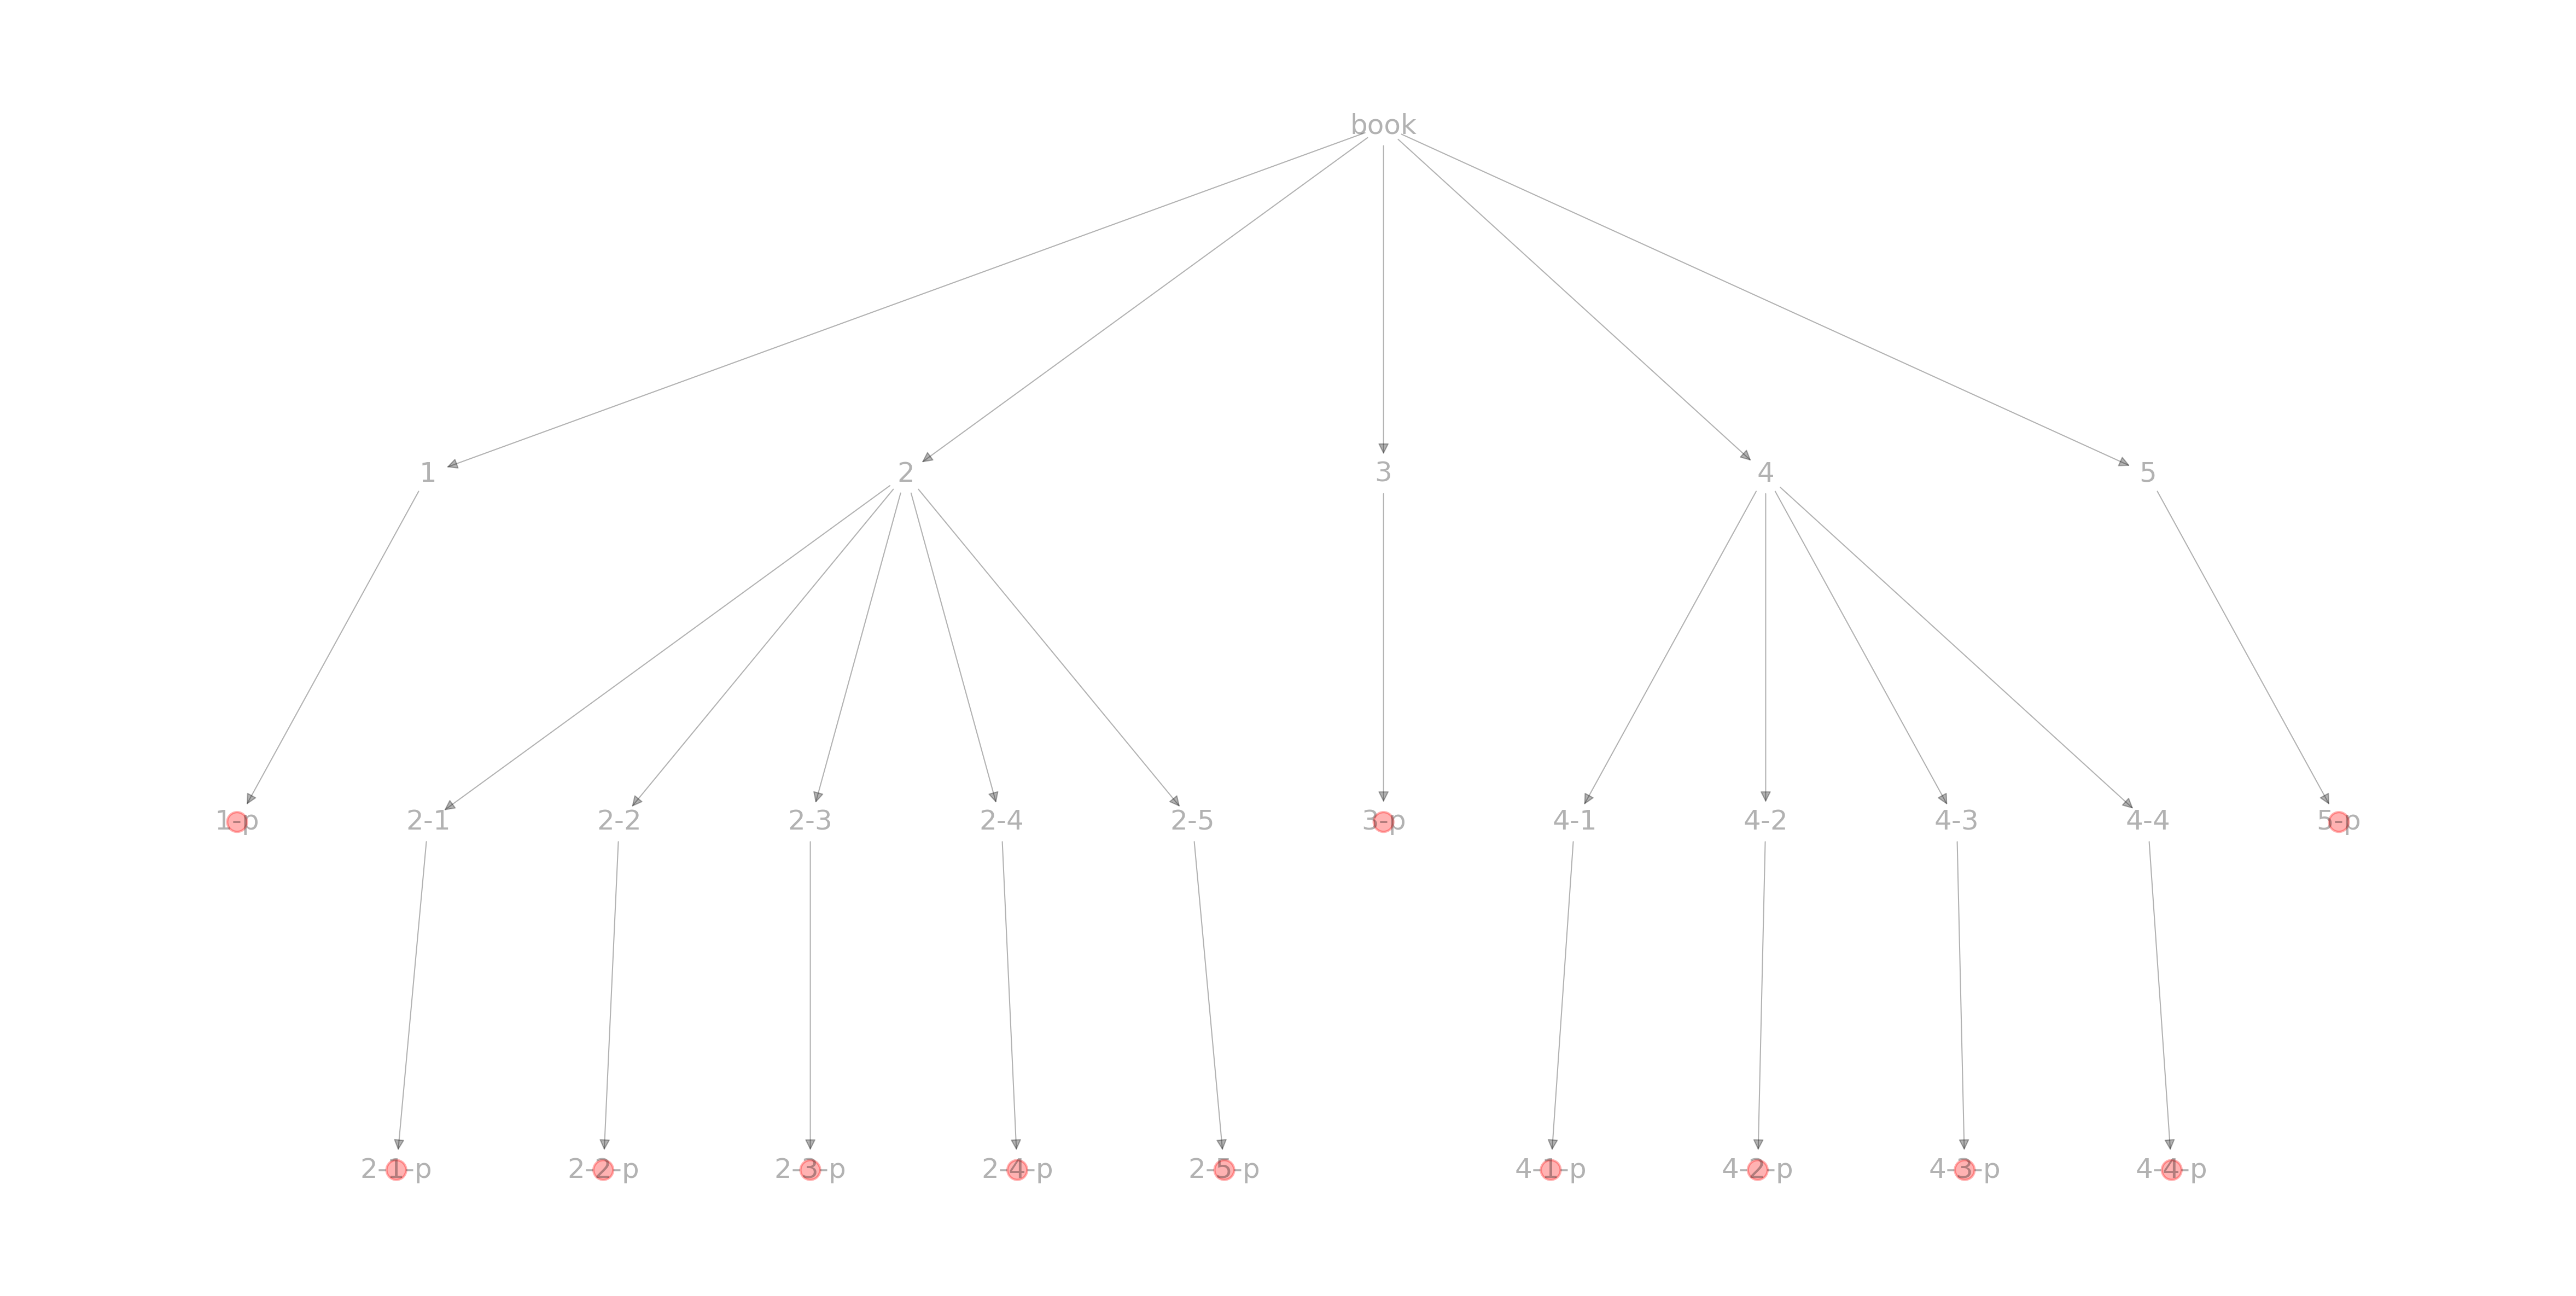

In [20]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## latexmkrc Generation

In [21]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

An error occurred while creating the file: [Errno 13] Permission denied: '/Users/hissain/.latexmkrc'


## LaTeX Generation Styles Setting

In [22]:
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))

# Adding title, author, and date to the preamble
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("author", book_author))
doc.preamble.append(Command("date", NoEscape(r"\today")))

# Generating the title and table of contents
doc.append(NoEscape(r"\maketitle"))  # Generates the title with author and date
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r"\newpage"))
doc.append(NoEscape(book_abstract))

# Setting up custom lstset for listings
doc.append(NoEscape(r'\lstset{backgroundcolor={\color[gray]{.90}}, breaklines=true, breakindent=10pt, basicstyle=\ttfamily\scriptsize, commentstyle={\itshape \color[cmyk]{1,0.4,1,0}}, classoffset=0, keywordstyle={\bfseries \color[cmyk]{0,1,0,0}}, stringstyle={\ttfamily \color[rgb]{0,0,1}}, frame=TBrl, framesep=5pt, numbers=left, stepnumber=1, numberstyle=\tiny, tabsize=4, captionpos=t}'))
#doc.generate_pdf("book_with_abstract", clean_tex=False)  # Generates the PDF

In [23]:
import re

def sanitize_content(content):
    lines = content.splitlines()
    
    def replace_markdown(line):
        # Headers
        if line.startswith('### '):  # Triple hash -> Subsubsection
            line = re.sub(r'^### (.*)', r'\\subsubsection{\1}', line)
        elif line.startswith('## '):  # Double hash -> Subsection
            line = re.sub(r'^## (.*)', r'\\subsection{\1}', line)
        elif line.startswith('# '):  # Single hash -> Section
            line = re.sub(r'^# (.*)', r'\\section{\1}', line)
        
        # Bold (**text** or __text__)
        line = re.sub(r'\*\*(.*?)\*\*', r'\\textbf{\1}', line)
        line = re.sub(r'__(.*?)__', r'\\textbf{\1}', line)
        
        # Italic (*text* or _text_)
        line = re.sub(r'\*(.*?)\*', r'\\textit{\1}', line)
        line = re.sub(r'_(.*?)_', r'\\textit{\1}', line)
        
        # Unordered lists (- or * or +)
        line = re.sub(r'^\s*[-*+] (.*)', r'\\item \1', line)
        
        return line
    
    # Prepare LaTeX document environment for lists
    def wrap_list_environment(lines):
        inside_itemize = False
        processed_lines = []
        
        for line in lines:
            if line.startswith('\\item '):
                if not inside_itemize:
                    processed_lines.append('\\begin{itemize}')
                    inside_itemize = True
            else:
                if inside_itemize:
                    processed_lines.append('\\end{itemize}')
                    inside_itemize = False
            processed_lines.append(line)
        
        if inside_itemize:
            processed_lines.append('\\end{itemize}')  # Close the environment if still open
        
        return processed_lines
    
    # Apply replacements
    updated_lines = [replace_markdown(line) for line in lines]
    updated_lines = wrap_list_environment(updated_lines)
    
    # Join lines back into a single string
    sanitized_content = '\n'.join(updated_lines)
    
    return sanitized_content

def escape_non_math_dollar_signs(tex_content):
    def replacer(match):
        return match.group(0).replace('$', '\\$') if match.group(0).count('$') == 1 else match.group(0)
    
    processed_content = re.sub(r'(?<!\\)(\$.*?\$)|(?<!\\)\$', replacer, tex_content)
    return processed_content

In [24]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    try:
        with open(tex_file_path, "r", encoding='UTF-8') as file:
            tex_content = file.read()
            tex_content = sanitize_content(tex_content)
            tex_content = escape_non_math_dollar_signs(tex_content)
            doc.append(NoEscape(tex_content))
    except Exception as e:
        print(e)

## PDF Generation

In [25]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=True)
    print('Generated!')
except:
    log_file_path = book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

Latexmk: This is Latexmk, John Collins, 17 March 2019, version: 4.63b.
Rule 'pdflatex': The following rules & subrules became out-of-date:
      'pdflatex'
------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  --interaction=nonstopmode -recorder  "/Users/hissain/git/github/llmexp/books_prof/quantum2/Understanding Quantum Computing.tex"'
------------
Latexmk: applying rule 'pdflatex'...
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/Users/hissain/git/github/llmexp/books_prof/quantum2/Understanding Quantum Com
puting.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/report.cls
Document Class: report 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/fontenc.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1enc.de